Illinois is famous for being one of the very few states in the country with negative population growth.  The objective of your final project is to:

Identify the key reasons for the declining population (what people like / dislike about Chicago / suburbs) by extracting meaningful insights from unstructured text
Provide actionable recommendations on what can be done to reverse this trend (how to make Chicago / suburbs more attractive)
You have access to a collection of ~200K news articles (about 500 MB).  The news articles are related to either Chicago and / or Illinois and you can access them in the following ways:

Download a data by following this think from your browser: https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json (Links to an external site.)
Use Spark on GCP news_final_project = spark.read.parquet('gs://msca-bdp-data-open/news_final_project')
Use Pandas from anywhere (your laptop, Colab or any cloud) df_news_final_project = pd.read_json('https://storage.googleapis.com/msca-bdp-data-open/news/news_final_project.json', orient='records', lines=True) 
 

To complete your assignment, I suggest considering the following steps:
Clean-up the noise (eliminate articles irrelevant to the analysis)
Detect major topics
Identify top reasons for population decline (negative sentiment)
Suggest corrective actions
Plot a timeline to illustrate how the sentiment is changing over time
Demonstrate how the city / state can attract new businesses (positive sentiment)
Leverage appropriate NLP techniques to identify organizations and people and apply targeted sentiment
Why businesses should stay in IL or move into IL?
Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
Whey residents should stay in IL or move into IL?
Create appropriate visualization to summarize your recommendations (i.e. word cloud chart or bubble chart)
 

Additional guidance:
Default sentiment will likely be wrong from any software package and will require some tweaking
Either keyword / dictionary approach or
Data annotation and development of custom classifier
Fine-tuning Transformer Pipeline
You are encouraged to explore a combination several techniques to identify key topics:
Topic modeling (i.e. LDA using gensim or ktrain) or using BERTopic
Classification (hand-label several topics on a sample and then train classifier)
Clustering (cluster topics around pre-selected keywords or word vectors)
Zero-shot (NLI) modeling
Please ensure your PowerPoint presentation (in PPTX or PDF format) is submitted to the course module as-is (not zipped). Otherwise we are unable to use Canvas SpeedGrader.
The presentation should look professional – not a collection of screenshots from your analytical software
Roughly 8-12 pages is reasonable for this kind of project but there are no strict restrictions.
On your slides you will want to provide:
Executive Summary
Methodology and source data overview
Actionable recommendations
Apply text summarization algorithms where possible to synthesize your insights
Please submit your actual program codes (Jupyter notebooks) along with your PowerPoint
The slides should be self-sufficient and after reading them, there should not be any need to read the notebook (we are still asking you to provide the notebooks as a proof or work though).
The slides should clearly answer all the questions and the answers should be supported with the plots/tables/numbers produced in the notebook based on the actual data.
The slides should contain the RIGHT amount of supporting material for each question, putting too much supporting material is as bad as putting too little: too much - you would not be able to keep the audience attention and your presentation would be a mess, too little - your statements would not look convincing.
Everything should be clear, logical, well organized, as simple as possible.  Use proper English and run spell check.
All the plots should be of production quality and easily readable. Fuzzy plots, untitled plots, unreadable labels, overlapping labels are unacceptable.
If you formatting somehow gets corrupted when you put your slides into Canvas (sometimes it happens), it is your responsibility to fix formatting. For example, try saving it in some other format like PDF, HTML.
Any statements you make should be supported by data. Only recommendations or goals of the project sections can contain elements not directly supported by the data
Please submit your actual program codes (i.e. Python Notebook) along with your PowerPoint – as a separate attachment
Your presentation should be targeted toward business audience and must not contain any code snippets
You are welcome to use any software packages of your choice to complete the assignment

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string

import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import spacy
import multiprocessing
import string

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
from pprint import pprint
from textblob import TextBlob

C:\Users\gargk\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\gargk\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\gargk\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
C:\Users\gargk\AppData\Roaming\Python\Python38\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\gargk\AppData\Roaming\Python\Python38\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
C:\Users\gargk\AppData\Roaming\Python\Python38\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment vari

In [2]:
import pandas as pd
df = pd.read_json('news_final_project.json', 
                                     orient='records', lines=True) 

df.head()

,date,language,title,text
0,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...
1,2022-01-06,english,"No deal, no school: Chicago cancels classes fo...",CHICAGO (AP) — Chicago school leaders canceled...
2,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,Chicago PD 9×11 “Lies” Season 9 Episode 11 Pro...
3,2022-01-06,english,Trump’s Solution for Chicago Public Schools? K...,Wise of Foolish?\nThe Chicago Tribune article ...
4,2022-01-06,english,"Family, friends, colleagues gathering today at...",The neighbors near Mashawn Plummer’s Portage P...


In [3]:
df.shape

(200119, 4)

In [4]:
df.dtypes

date        datetime64[ns]
language            object
title               object
text                object
dtype: object

In [5]:
df.isna().sum()

date        0
language    0
title       0
text        0
dtype: int64

In [6]:
df.language.value_counts()

english    200119
Name: language, dtype: int64

## Preprocessing the text

In [7]:
df['text_clean'] = df['text'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', '', str(x)))

pd.set_option('display.max_colwidth', 900)
df[['text', 'text_clean']].head(5)

texts = df['text_clean'].tolist()
texts[:1]

['CHICAGO AP  Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID19 safety protocols in the nations thirdlargest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didnt work and schools can safely remain open with protocols in place. The move to cancel classes and activities Thursday affects roughly 350,000 students and came after closeddoor negotiations Wednesday failed to produce a deal. The issues include metrics for closing schools. We have no choice but to cancel classes tomorrow, Schools CEO Pedro Martinez said at a Wednesday evening news conference. Students returned to class Monday after a twoweek winter break with COVID19 infections and hospitalizations fueled by the omicron variant at record levels. School district

In [8]:
%%time

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
        
data_list = df['text'].tolist()        
data_tokens = list(sent_to_words(data_list))

CPU times: total: 2min 37s
Wall time: 2min 37s


In [9]:
del data_list

In [10]:
%%time

# bigram = gensim.models.Phrases(data_tokens, min_count=5, threshold=100)
# trigram = gensim.models.Phrases(bigram[data_tokens], threshold=100)

bigram = gensim.models.Phrases(data_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[data_tokens], threshold=1)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

CPU times: total: 10min 14s
Wall time: 10min 14s


In [11]:
%%time

stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

CPU times: total: 0 ns
Wall time: 9 ms


In [12]:
%%time

# Remove Stop Words
data_tokens_nostops = remove_stopwords(data_tokens)

# Create n-grams
data_words_bigrams = make_bigrams(data_tokens_nostops)
# data_words_trigrams = make_trigrams(data_tokens_nostops)

# Combine tokens and n-grams
# data_tokens_cobnined = data_tokens_nostops + data_words_bigrams + data_words_trigrams
data_tokens_cobined = data_words_bigrams

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])

# Lemmatize text keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_tokens_cobined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(*data_lemmatized[:1])

['thursday', 'day', 'fail', 'protocol', 'nation_third', 'district', 'chicago_teacher', 'revert', 'remote_instruction', 'infection', 'deal', 'chicago_public', 'schools_leader', 'say', 'remote_learne', 'work', 'schools_safely', 'remain_open', 'protocol', 'place', 'move', 'cancel_classe', 'activity', 'thursday_affect', 'roughly_student', 'come', 'negotiations_wednesday', 'fail', 'produce_deal', 'metric', 'choice', 'cancel_classe', 'two_week', 'covid_infection', 'fuel', 'omicron_variant', 'school_district', 'nationwide', 'grapple', 'issue', 'opt', 'ramp', 'virus_teste', 'tweaking_protocol', 'adjustment', 'response', 'jen_psaki', 'joe_biden', 'day_earlier', 'say', 'wednesday', 'country', 'schools_safely', 'open', 'include', 'call', 'say', 'teacher', 'want', 'return', 'subside', 'rather', 'classes_teache', 'rather', 'right', 'middle', 'breaking_records', 'hospital', 'full', 'say', 'wednesday_morne', 'teacher', 'parent', 'approve', 'members_called', 'remote_instruction', 'cases_substantially'

In [13]:
del data_tokens

In [14]:
%%time

# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
dictionary = corpora.Dictionary(data_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in data_lemmatized]

CPU times: total: 31.7 s
Wall time: 31.8 s


## Implementing LDA

In [15]:
num_processors = multiprocessing.cpu_count()
num_processors

workers = num_processors-1

print(f'Using {workers} workers')

Using 11 workers


In [16]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()



import time
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [40]:
%%time
# supporting function
corpus_train = corpora.Dictionary(data_lemmatized)
def compute_coherence_values(corpus, corpus_train, k, a, b):
    
    lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=corpus_train,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=workers)

    coherence_model_lda = gensim.models.coherencemodel.CoherenceModel(model=lda_model, corpus=corpus_train, 
                                                                      texts=data_lemmatized, coherence='c_v')

    return coherence_model_lda.get_coherence()



grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 1
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics+1, step_size)

# Alpha parameter
# alpha = list(np.arange(0.01, 1, 0.3))
# alpha.append('symmetric')
# alpha.append('asymmetric')
alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')
beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
#                gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               doc_term_matrix]
# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], corpus_train=corpus_train, 
                                              k=k, a=a, b=b)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
#                 print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
lda_tuning = pd.DataFrame(model_results)
# lda_tuning.to_csv(os.path.join(path_lda, 'lda_tuning_results1.csv'), index=False)

LDA will execute 15 iterations
Completed model based on 1 LDA topics. Finished 6.7% of LDA runs
Execution time to calculate for topic 1: 0hour:8min:21sec
Completed model based on 2 LDA topics. Finished 13.3% of LDA runs
Execution time to calculate for topic 2: 0hour:9min:17sec
Completed model based on 3 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 3: 0hour:9min:36sec
Completed model based on 4 LDA topics. Finished 26.7% of LDA runs
Execution time to calculate for topic 4: 0hour:9min:54sec
Completed model based on 5 LDA topics. Finished 33.3% of LDA runs
Execution time to calculate for topic 5: 0hour:10min:10sec
Completed model based on 6 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 6: 0hour:10min:25sec
Completed model based on 7 LDA topics. Finished 46.7% of LDA runs
Execution time to calculate for topic 7: 0hour:10min:36sec
Completed model based on 8 LDA topics. Finished 53.3% of LDA runs
Execution time to calculate for t

In [41]:
lda_tuning.to_csv('lda_tuning_results2.csv', index=False)

In [17]:
import pandas as pd
lda_tuning = pd.read_csv('lda_tuning_results2.csv')

In [18]:
lda_tuning.sort_values(by=['Coherence'], ascending=False).head(10)

,Topics,Alpha,Beta,Coherence
5,6,asymmetric,auto,0.499614
11,12,asymmetric,auto,0.477696
10,11,asymmetric,auto,0.474563
12,13,asymmetric,auto,0.467675
13,14,asymmetric,auto,0.467064
14,15,asymmetric,auto,0.461920
4,5,asymmetric,auto,0.445588
6,7,asymmetric,auto,0.423902
9,10,asymmetric,auto,0.415127
8,9,asymmetric,auto,0.411842


<AxesSubplot:xlabel='Topics', ylabel='Coherence'>

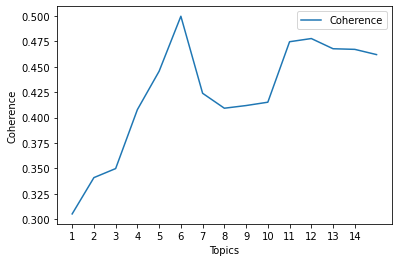

In [19]:
lda_tuning.plot(x ='Topics', y='Coherence', kind = 'line', xticks=range(1,15), ylabel = 'Coherence')

In [20]:
lda_tuning_best = lda_tuning.loc[[5]] # Best params for N=9


tuned_topics = int(lda_tuning_best['Topics'].to_string(index=False))


# Since the values for Alpha and Beta can be float, symmetric and asymmetric, we will either strip or convert to float
try:
    tuned_alpha = float(lda_tuning_best['Alpha'].to_string(index=False))
except:
    tuned_alpha = lda_tuning_best['Alpha'].to_string(index=False).strip()
    

try:
    tuned_beta = float(lda_tuning_best['Beta'].to_string(index=False))
except:
    tuned_beta = lda_tuning_best['Beta'].to_string(index=False).strip()    
    
print(f'Best Parameters: Topics: {tuned_topics}, Alpha: {tuned_alpha}, Beta: {tuned_beta}')

Best Parameters: Topics: 6, Alpha: asymmetric, Beta: auto


In [21]:
%%time

tuned_lda_model = LdaMulticore(corpus=doc_term_matrix,
                       id2word=dictionary,
                       num_topics=tuned_topics,
                       random_state=100,
                       passes=10,
                       alpha=tuned_alpha,
                       eta=tuned_beta,
                       workers = workers)



coherence_model_lda = CoherenceModel(model=tuned_lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5010804564822159
CPU times: total: 11min 22s
Wall time: 11min 41s


In [22]:
%%time

lda_display = gensimvis.prepare(tuned_lda_model, doc_term_matrix, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(lda_display)

C:\Users\gargk\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


CPU times: total: 2min 23s
Wall time: 2min 33s


Topics:
1. Talks about schools in chicago- remote learning and covid
2. Talks about games - game, team, season, play, bear
3. About police and possibly crimes
4. About Buisness and stocks.
5. Talks about lawyers and cases - divorce_lawyer, rehab, alcohol_drug, roofing
6. Talks about prize and winning - sweepstake, prize, winner, sponsor. (Some negatives like - accident lawyer, truck accident, disqualify, arbitration)

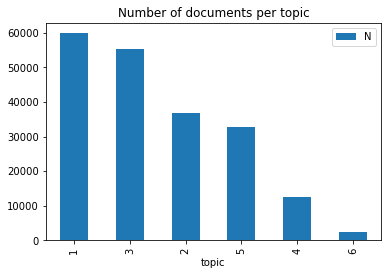

In [49]:
#Number of documents per topic
all_topics = tuned_lda_model.get_document_topics(doc_term_matrix, minimum_probability=0.0)
all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()
all_topics_df = pd.DataFrame(all_topics_numpy)
all_topics_df['topic_num'] = all_topics_df.idxmax(axis=1)
all_topics_df['topic_num'] = all_topics_df['topic_num'] + 1
ax = all_topics_df.topic_num.value_counts().reset_index().rename(columns={'index':'topic', 
                                                                          'topic_num': 'documents'}).plot.bar(x = 'topic', 
                                                                                                              y = 'documents',
                                                                                                             title='Number of documents per topic')
ax.legend('Number of documents per topic')

In [68]:
df['topic'] = all_topics_df['topic_num'].values
df.head()

,date,language,title,text,text_clean,topic
0,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day","CHICAGO (AP) — Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID-19 safety protocols in the nation’s third-largest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didn’t work and schools can safely remain open with protocols in place. The move to cancel classes and activities Thursday affects roughly 350,000 students and came after closed-door negotiations Wednesday failed to produce a deal. The issues include metrics for closing schools. “We have no choice but to cancel classes tomorrow,” Schools CEO Pedro Martinez said at a Wednesday evening news conference. Students returned to class Monday after a two-week winter b...","CHICAGO AP Chicago school leaders canceled classes Thursday for a second consecutive day after failing to reach agreement with the teachers union over COVID19 safety protocols in the nations thirdlargest school district. The Chicago Teachers Union sought to revert to remote instruction during the latest surge of infections and while both sides hammer out a deal. But Chicago Public Schools leaders have said remote learning didnt work and schools can safely remain open with protocols in place. The move to cancel classes and activities Thursday affects roughly 350,000 students and came after closeddoor negotiations Wednesday failed to produce a deal. The issues include metrics for closing schools. We have no choice but to cancel classes tomorrow, Schools CEO Pedro Martinez said at a Wednesday evening news conference. Students returned to class Monday after a twoweek winter break with C...",1
1,2022-01-06,english,"No deal, no school: Chicago cancels classes for a 2nd day | National | couriernews.com","CHICAGO (AP) — Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID-19 safety protocols in the nation's third-largest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID-19 surge while both sides negotiate, prompting district officials to cancel classes two days after students returned from winter break. Chicago Public Schools, like most other districts, has rejected retuning to remote learning, saying it worsened racial inequities and was detrimental to academic performance, mental health and attendance. District officials insist schools can safely remain open with protocols in place. Both sides negotiated behind closed doors Wednesday afternoon but failed to produce ...","CHICAGO AP Chicago school leaders canceled classes for a second straight day after failing to reach an agreement Wednesday with the teachers union over remote learning and other COVID19 safety protocols in the nations thirdlargest school district. The Chicago Teachers Union, which voted to revert to online instruction, told teachers to stay home Wednesday during the latest COVID19 surge while both sides negotiate, prompting district officials to cancel classes two days after students returned from winter break. Chicago Public Schools, like most other districts, has rejected retuning to remote learning, saying it worsened racial inequities and was detrimental to academic performance, mental health and attendance. District officials insist schools can safely remain open with protocols in place. Both sides negotiated behind closed doors Wednesday afternoon but failed to produce an agre...",1
2,2022-01-06,english,Watch ‘Chicago P.D.’ Preview Wednesday,"Chicago PD 9×11 “Lies” Season 9 Episode 11 Promo – Voight employs his new informant to help sol

In [111]:
df.to_csv("news_final_project_with_topics.csv", index = False)